# Imports

In [308]:
import spotipy
import re

# math and dataframes
import pandas as pd
import numpy as np

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [309]:
# all songs with audio features (combined from 3 sources)
df_10M = pd.read_parquet('df_10M.parquet')

# all Billboard 100 lists, audio features included where possible
df_B100 = pd.read_parquet('df_B100.parquet')

# all unique songs from the Billboard 100 lists, audio features included where possible
df_B100_songs = pd.read_parquet('df_B100_songs.parquet')

In [310]:
# confirm import worked (B100 songs are all in df_10M, no duplicates)
id_B100 = set(df_B100_songs[~df_B100_songs.id.isnull()].id)
len(id_B100), df_10M[df_10M.id.isin(id_B100)].shape[0]
# GOOD!

(22189, 22189)

# ATTEMPT AT OUTLIERS (need more QA / data cleaning)

In [324]:
# longest and shortest songs on B100
df_B100_songs.describe().T[['min', 'max']].rename({'duration_ms': 'minutes'}, axis=1).loc[['duration_ms']] / 60_000

,min,max
duration_ms,0.504,26.019


In [325]:
# yep, actually 26 minutes
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.max()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
17675,7ERSQrRptZVM7q3VOdM7OL,Tubular Bells,Mike Oldfield,album rock,1973-02-01,0.564,0.374,1561133,0.219,0.560,4,0.114,-19.104,0,0.034,103.535,4,0.058


In [326]:
# can't verify this using spotify's search
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.min()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
23319,13F8uvVT4s364jof2dn6XU,Fire,Subway,kirtan,2006-01-01,0.197,0.351,30213,0.532,0.110,6,0.443,-29.658,1,0.067,129.338,3,0.227


# QA part 2
### INVESTIGATE

##### get a temporary authorization token from: https://developer.spotify.com/console/get-search-item

In [ ]:
# input the temporary token
TEMP_TOKEN = input('Enter token: ')

# create a spotify object
spotify = spotipy.Spotify(auth=TEMP_TOKEN)

In [ ]:
def find_ids(track_title, artist_name):

    track_info = spotify.search(q='artist:' + artist_name + ' track:' + track_title, type='track')
    
    if track_info['tracks']['items'] == []:  # if track doesn't exist on Spotify
        return 'MISSING'
    else:
        track_ids = []
        number_of_results = len(track_info['tracks']['items'])
        
        # check if there is a better match
        for i in range(number_of_results):
            track_ids.append(track_info['tracks']['items'][i]['id'])
        
        # if we made it through the loop without returning, note 'MISSING' and return the 0th id
        return track_ids

In [ ]:
fire_ids = find_ids('fire', 'subway')
fire_ids

In [ ]:
spotify.track(fire_ids[0])['artists'][0]['name'], spotify.track(fire_ids[0])['name']

In [ ]:
output = []
for track_id in fire_ids:
    track = spotify.track(track_id)
    output.append([track['artists'][0]['name'], track['name']])
    
output

* this track doesn't seem to be on spotify, but they have lyrics
* the algorithm would have defaulted to populating data for the first result, if there was no exact match
https://open.spotify.com/track/7p2e6DPXynAHq4m3uM3pLO

In [ ]:
id_from_shortest_song = '13F8uvVT4s364jof2dn6XU'
track = spotify.track(id_from_shortest_song)
[track['artists'][0]['name'], track['name']]

# not sure why this one made it to the top of the list...

In [ ]:
### REDO METADATA IDS ###

# Spotify 1.2M+ Songs
# via:  https://www.kaggle.com/datasets/
url_1M_songs = r'D:\RYERSON\820\Datasets\Spotify 1.2M+ Songs\tracks_features.csv'

# create the dataframe with the large number of songs metadata
df_1M_songs = pd.read_csv(url_1M_songs)

# make a list of song ids from the 1M dataset
metadata_ids_csv = df_1M_songs.id.to_list()


# all ids from the SQLite database
metadata_ids_SQL = pd.read_csv('all_ids_sql.csv', header=None, names=['id'])
metadata_ids_SQL = metadata_ids_SQL.id.to_list()

# audio feature data not imported yet (very large)


# list of ids for all of our known metadata
all_metadata_ids = set(metadata_ids_csv + metadata_ids_SQL) # set() faster to search, and no duplicates
len(all_metadata_ids)

In [ ]:
id_from_shortest_song in all_metadata_ids

In [ ]:
df_1M_songs[df_1M_songs.id==id_from_shortest_song]

In [ ]:
df_10M[df_10M.id==id_from_shortest_song]

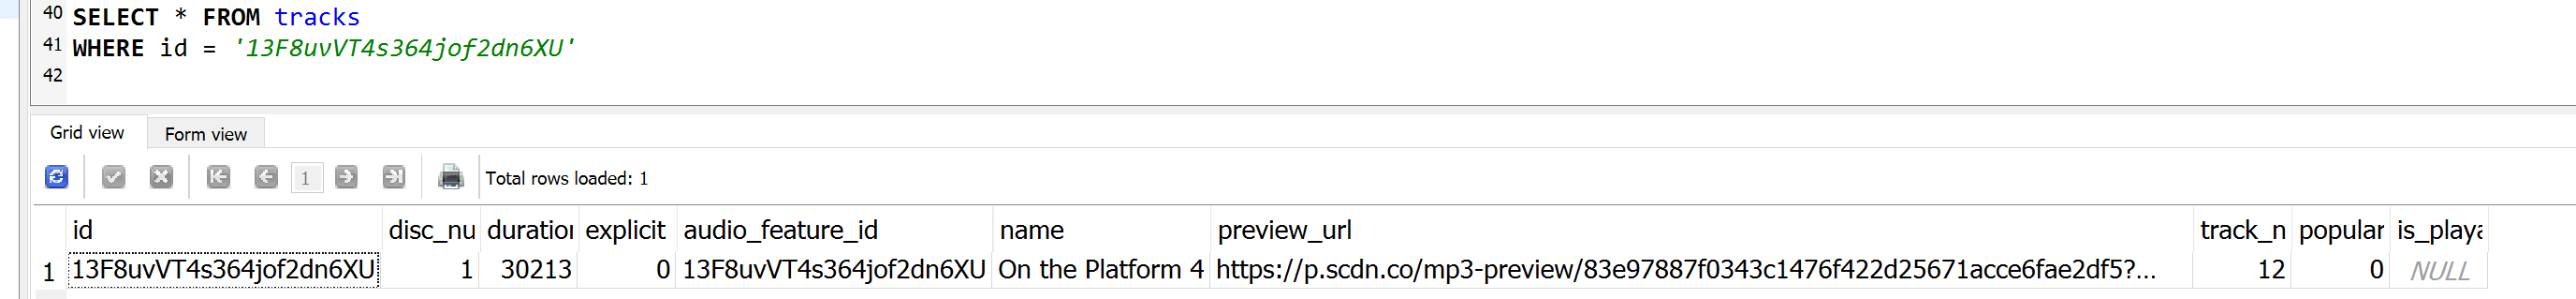

* this was a false positive
    * the song list from the spotify api search returned a match that was in the other dataset, but wasn't the actual song
    * should I redo phase 1 with a check for only exact matches for name?
    * alternative 2, confirm that song title matches exactly with spotify id song title
    * yuck
    * also, this would have overwritten songs from SQL with ids matching B100 songs
    

### check for mismatched names

In [ ]:
matching_B100 = df_B100_songs[['id', 'song', 'artist']].copy()
matching_B100 = matching_B100.dropna().reset_index(drop=True)
track_id_list = matching_B100.id.tolist()

matching_B100['actual_song'] = ''
matching_B100['actual_artist'] = ''

matching_B100.head()

##### get a temporary authorization token from: https://developer.spotify.com/console/get-search-item

In [ ]:
# input the temporary token
TEMP_TOKEN = input('Enter token: ')

# create a spotify object
spotify = spotipy.Spotify(auth=TEMP_TOKEN)

In [ ]:
counter = 0
for i, row in matching_B100.iterrows():
    
    if i < 0:  # where we timed out last time
        continue
    
    track_id = matching_B100.iloc[i]['id']
    
    try:
        track = spotify.track(track_id)
        matching_B100.iloc[i]['actual_song'] = track['name']
        matching_B100.iloc[i]['actual_artist'] = track['artists'][0]['name']
    except:  # any error should yield missing
        matching_B100.iloc[i]['actual_song'] = 'MISSING'
        matching_B100.iloc[i]['actual_artist'] = 'MISSING'
    
    if counter % 100 == 0:
        print(counter, end=' ')
    if counter % 1000 == 0:
        print()
        matching_B100.to_parquet('matching_B100_TEMP.parquet')
        
    counter += 1

matching_B100.to_parquet('matching_B100_FINISHED.parquet')

In [ ]:
matching_B100.head()

### Reimport and check for false positives

In [ ]:
matching_B100 = pd.read_parquet('matching_B100_FINISHED.parquet')

In [ ]:
# helper function to clean artist and song data
def clean_text(text_input):
    text_input = text_input.strip().lower()
    text_input = re.sub(r'&', 'and', text_input)  # replaces & with 'and'
    text_input = re.sub(r'and.+', '', text_input)  # removes text after the 'and'
    text_input = re.compile(r'the').sub('', text_input)  # remove all 'the' (maybe just need the 1st word?)
    text_input = re.sub(r',.+', '', text_input)  # removes all misc artists, after comma 
    text_input = re.sub(r'(?:feat).+', '', text_input)  # removes all misc artists, after 'feat' 
    text_input = re.sub(r'\(.+', '', text_input)  # removes text after first bracket
    text_input = re.sub(r'\-.+', '', text_input)  # removes text after first dash
    text_input = re.compile(r'[^a-zA-Z 0-9]').sub('', text_input)  # remove punctuation
    text_input = re.sub(' +', ' ', text_input)  # remove multiple spaces
    return text_input.strip()

In [ ]:
text_input = 'Gary Lewis & The Playboys'
clean_text(text_input)

In [ ]:
matching_B100.head()

In [ ]:
matching_B100['song_match'] = matching_B100[['song']].applymap(clean_text).values == matching_B100[['actual_song']].applymap(clean_text).values
matching_B100['artist_match'] = matching_B100[['artist']].applymap(clean_text).values == matching_B100[['actual_artist']].applymap(clean_text).values

In [ ]:
# number OK, number of songs with at least 1 error, number of song errors, number of artist errors, number of double errors

(
    matching_B100[(matching_B100['song_match'] & matching_B100['artist_match'])].shape[0],
    matching_B100[~(matching_B100['song_match'] & matching_B100['artist_match'])].shape[0],
    matching_B100[~(matching_B100['song_match'])].shape[0],
    matching_B100[~(matching_B100['artist_match'])].shape[0],
    matching_B100[~(matching_B100['song_match'] | matching_B100['artist_match'])].shape[0],
)

#  OK, either, song, artist, both bad

In [ ]:
# let's take a look
matching_B100[~(matching_B100['song_match'] & matching_B100['artist_match'])].sample(20)
# most look good

In [ ]:
# what if both are wrong
matching_B100[~(matching_B100['song_match'] | matching_B100['artist_match'])].sample(20)
# most look wrong

In [ ]:
wrong = [
    '1XduhVDrsLuMWk0fT0kbOx' # cover song of the song we wanted
]

In [ ]:
# if we only exclude double false flags, this one gets included
matching_B100[matching_B100.id == '1XduhVDrsLuMWk0fT0kbOx']

In [ ]:
# maybe we need to redo id gathering for single false flags (currently 1716)

# first look at double true to see how good it is:
matching_B100[(matching_B100['song_match'] & matching_B100['artist_match'])].sample(20)
# all good (20 samples)
# all good (20 samples)
# all good (20 samples)
# 

# Need to Re-Gather ID data

* algorithm:
    * start with a list of ids to exclude
        * drop from both dataframes
            * B100 and 10M
    * check for match
        * look for exact matches using full text
        * look for exact matches using clean text
        * EXCLUDE
    * if match
        * look up audio features
        * look up genres
        
* after algo
    * re-merge dataframes and save results       
    


### STEP 1: Create QA Dataframe

In [ ]:
allbad = matching_B100[~(matching_B100['song_match'] | matching_B100['artist_match'])].id.tolist()
onebad = matching_B100[~(matching_B100['song_match'] & matching_B100['artist_match'])].id.tolist()
onebad = [x for x in onebad if x not in allbad]

In [ ]:
# these lists are the correct length
len(onebad), len(allbad), len(onebad) + len(allbad)

In [ ]:
df_QA2 = matching_B100[~(matching_B100['song_match'] & matching_B100['artist_match'])].copy()

df_QA2['id_status'] = ''
df_QA2.loc[df_QA2.id.isin(allbad), 'id_status'] = 'BAD'
df_QA2.loc[df_QA2.id.isin(onebad), 'id_status'] = 'suspect'

df_QA2 = df_QA2.rename(columns = {
    'id': 'possibly_incorrect_id',
    'actual_song': 'song_from_old_id',
    'actual_artist': 'artist_from_old_id'
}).drop(['song_match', 'artist_match'], axis=1)

In [ ]:
# add columns before importing from Spotify API
df_QA2['CORRECT_ID'] = pd.NA  # use with full match (minus 'the' / punctuation)
df_QA2['PROBABLE_ID'] = pd.NA  # use if that fails, but matches with fully cleaned text
df_QA2['genre'] = pd.NA
df_QA2['release_date'] = pd.to_datetime(np.nan)
df_QA2['acousticness'] = np.nan
df_QA2['danceability'] = np.nan
df_QA2['duration_ms'] = np.nan
df_QA2['energy'] = np.nan
df_QA2['instrumentalness'] = np.nan
df_QA2['key'] = np.nan
df_QA2['liveness'] = np.nan
df_QA2['loudness'] = np.nan
df_QA2['mode'] = np.nan
df_QA2['speechiness'] = np.nan
df_QA2['tempo'] = np.nan
df_QA2['time_signature'] = np.nan
df_QA2['valence'] = np.nan

In [ ]:
df_QA2.shape

In [ ]:
# reindex and save dataframe for use later
df_QA2 = df_QA2.reset_index(drop=True)
df_QA2.to_parquet('df_QA2_STEP1COMPLETE.parquet')

### STEP 2:  populate correct or probable IDs from Spotify API
also update the lists of bad and good IDs

In [ ]:
df_QA2 = pd.read_parquet('df_QA2_STEP1COMPLETE.parquet')

##### get a temporary authorization token from: https://developer.spotify.com/console/get-search-item

In [ ]:
# input the temporary token
TEMP_TOKEN = input('Enter token: ')

# create a spotify object
spotify = spotipy.Spotify(auth=TEMP_TOKEN)

In [ ]:
# helper functions

def find_all_tracks(track_title, artist_name):
    """ returns list of lists ['id', 'song', 'artist'] """
    track_info = spotify.search(q='artist:' + artist_name + ' track:' + track_title, type='track')
    
    if track_info['tracks']['items'] == []:  # if track doesn't exist on Spotify
        return 'MISSING'
    else:
        all_tracks = []
        number_of_results = len(track_info['tracks']['items'])
        
        # check if there is a better match
        for i in range(number_of_results):
            track_id = track_info['tracks']['items'][i]['id']
            artist_name = track_info['tracks']['items'][i]['artists'][0]['name']
            song_name = track_info['tracks']['items'][i]['name']
            all_tracks.append([track_id, song_name, artist_name])
        
        # if we made it through the loop without returning, note 'MISSING' and return the 0th id
        return all_tracks
    

def remove_punctuation(text_input):
    text_input = re.sub(r'&', 'and', text_input)  # replaces & with 'and'
    text_input = re.compile(r'[^a-zA-Z 0-9]').sub('', text_input)
    return text_input.lower().strip()

    
def clean_text(text_input):
    text_input = text_input.strip().lower()
    text_input = re.sub(r'&', 'and', text_input)  # replaces & with 'and'
    text_input = re.sub(r'and.+', '', text_input)  # removes text after the 'and'
    text_input = re.compile(r'the').sub('', text_input)  # remove all 'the' (maybe just need the 1st word?)
    text_input = re.sub(r',.+', '', text_input)  # removes all misc artists, after comma 
    text_input = re.sub(r'(?:feat).+', '', text_input)  # removes all misc artists, after 'feat' 
    text_input = re.sub(r'\(.+', '', text_input)  # removes text after first bracket
    text_input = re.sub(r'\-.+', '', text_input)  # removes text after first dash
    text_input = re.compile(r'[^a-zA-Z 0-9]').sub('', text_input)  # remove punctuation
    text_input = re.sub(' +', ' ', text_input)  # remove multiple spaces
    return text_input.strip()

In [ ]:
# loop 

counter = 0

for i, row in df_QA2.iterrows():
    
    if i < 0:  # where we timed out last time
        continue
        
    if counter % 10 == 0:
        print(counter, end=' ')
    if counter % 100 == 0:
        print()
    
    counter += 1
    
    # these are the actual song and artist from the Billboard Hot 100
    song = df_QA2.iloc[i]['song']
    artist = df_QA2.iloc[i]['artist']
    
    # get all track info from Spotify API matching 'song' and 'artist'
    all_track_info = find_all_tracks(song, artist)
    
    # restart loop if there are no results
    if all_track_info == 'MISSING':
        continue
    
    is_exact_match = False
    
    # first subloop - check for direct matched
    for track_info in all_track_info:
        temp_id = track_info[0]
        temp_song = track_info[1]
        temp_artist = track_info[2]
        
        # if there is an exact text match
        is_exact_match = remove_punctuation(temp_song) == remove_punctuation(song) and \
                         remove_punctuation(temp_artist) == remove_punctuation(artist)
        
        # continue subloop
        if is_exact_match:
            df_QA2.loc[df_QA2.index[i], 'CORRECT_ID'] = temp_id
            df_QA2.loc[df_QA2.index[i], 'id_status'] = 'CONFIRMED'
            continue
    
    # if we confirmed, go to the next row item
    if df_QA2.loc[df_QA2.index[i], 'id_status'] != 'CONFIRMED':
            
        # second subloop - check for indirect matches (shouldn't run if direct match occurs)
        for track_info in all_track_info:
            temp_id = track_info[0]
            temp_song = track_info[1]
            temp_artist = track_info[2]

            # if there is a probable text match
            is_probable_match = clean_text(temp_song) == clean_text(song) and \
                                clean_text(temp_artist) == clean_text(artist)

            if is_probable_match:
                df_QA2.loc[df_QA2.index[i], 'PROBABLE_ID'] = temp_id
                df_QA2.loc[df_QA2.index[i], 'id_status'] = 'LIKELY'
                continue
        

df_QA2.to_parquet('df_QA2_STEP2COMPLETE.parquet')

##### check results and prep for step 3

In [ ]:
corrected_ids = df_QA2[~df_QA2.CORRECT_ID.isna()].shape[0]
possibly_corrected_ids = df_QA2[~df_QA2.PROBABLE_ID.isna()].shape[0]
corrected_ids, possibly_corrected_ids
# (558, 248) # old values

In [ ]:
df_QA2[~df_QA2.PROBABLE_ID.isna()].head()

##### which songs should be reimported from SQL?
* songs found in QA where ID changed
* songs with 'BAD' id status

In [ ]:
# these should be left in the original dataframe
df_QA2[~df_QA2.CORRECT_ID.isna()].query('possibly_incorrect_id == CORRECT_ID').shape[0]

In [ ]:
# no probably correct id match the original id, none to keep
df_QA2[~df_QA2.PROBABLE_ID.isna()].query('possibly_incorrect_id == PROBABLE_ID').shape[0]

In [ ]:
df_QA2[~df_QA2.PROBABLE_ID.isna()].shape[0]

In [ ]:
# these need to be fixed updated audio features
id_to_reimport_from_SQL = df_QA2[~df_QA2.CORRECT_ID.isna()].query('possibly_incorrect_id != CORRECT_ID').possibly_incorrect_id.to_list()
len(id_to_reimport_from_SQL)

In [ ]:
id_to_reimport_from_SQL = id_to_reimport_from_SQL + df_QA2[~df_QA2.PROBABLE_ID.isna()].possibly_incorrect_id.to_list()
len(id_to_reimport_from_SQL)

In [ ]:
id_to_reimport_from_SQL = id_to_reimport_from_SQL + df_QA2[df_QA2.id_status == 'BAD'].possibly_incorrect_id.to_list()
len(id_to_reimport_from_SQL)

In [ ]:
# check for duplicates
len(id_to_reimport_from_SQL) == len(set(id_to_reimport_from_SQL))
# none, all good

In [ ]:
all_audio_features_sql = pd.read_csv('all_audio_features_sql.csv')

In [ ]:
sql_reimport = all_audio_features_sql[all_audio_features_sql.id.isin(id_to_reimport_from_SQL)]
sql_reimport = sql_reimport.rename({
    'name:1': 'artist',
    'name': 'song',
    'duration:1': 'duration_ms'
}, axis=1)[[
    'id', 'song', 'artist', 'acousticness', 'danceability', 'duration_ms', 
    'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 
    'speechiness', 'tempo','time_signature', 'valence'
]].drop_duplicates(['id']).reset_index(drop=True)
# note: CONFIRMED: genre and release_date were looked up from ID, just merge 'song' and 'artist'

In [ ]:
sql_reimport.head()

In [ ]:
sql_reimport.shape

In [ ]:
# just update song and artist in df_10M
sql_reimport.to_parquet('sql_reimport.parquet')

##### which songs should be left alone?

In [ ]:
df_QA2.id_status.unique()

In [ ]:
df_QA2[df_QA2.id_status == 'CONFIRMED'].query('possibly_incorrect_id == CORRECT_ID').shape[0]

In [ ]:
df_QA2[df_QA2.id_status == 'LIKELY'].query('possibly_incorrect_id == PROBABLE_ID').shape[0]

In [ ]:
# maybe
df_QA2[df_QA2.id_status == 'suspect'].shape[0]

In [ ]:
# most of these are good, are we better dropping or keeping?
df_QA2[df_QA2.id_status == 'suspect'].sample(10)

In [ ]:
# definitely do not keep
df_QA2[df_QA2.id_status == 'BAD'].shape[0]

##### which songs need new audio features from Spotify

In [ ]:
# old ids
list_to_api_AF = df_QA2[~df_QA2.CORRECT_ID.isna()].query('possibly_incorrect_id != CORRECT_ID').possibly_incorrect_id.to_list()
list_to_api_AF = list_to_api_AF + df_QA2[~df_QA2.PROBABLE_ID.isna()].query('possibly_incorrect_id != PROBABLE_ID').possibly_incorrect_id.to_list()
len(list_to_api_AF)

In [ ]:
len(list_to_api_AF) == len(set(list_to_api_AF))

In [ ]:
# songs that need audio features again
df_need_AF = df_QA2[df_QA2.possibly_incorrect_id.isin(list_to_api_AF)].drop(['possibly_incorrect_id', 'song_from_old_id', 'artist_from_old_id', 'id_status'], axis=1).reset_index(drop=True).copy()

### STEP 3:  create a new dataframe for looking up audio features and genre, where applicable

In [ ]:
df_need_AF['id'] = df_need_AF[['CORRECT_ID', 'PROBABLE_ID']].apply(lambda x: ''.join(x.dropna()), axis=1)

In [ ]:
df_need_AF = df_need_AF[[
    'id', 'song', 'artist', 'genre', 'release_date',
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
    'speechiness', 'tempo', 'time_signature', 'valence'
]]

In [ ]:
df_need_AF.to_parquet('df_need_AF.parquet')

In [ ]:
df_QA2 = pd.read_parquet('df_QA2_STEP2COMPLETE.parquet')
df_need_AF = pd.read_parquet('df_need_AF.parquet')

In [ ]:
df_need_AF.head()

In [ ]:
# redo genre ordered list

df_track_genres_SQL = pd.read_csv('track_genre_sql.csv')

genre_counts = (
    df_track_genres_SQL[['track_id','genre_id']]
    .groupby(['genre_id'])
    .count()
    .sort_values('track_id', ascending=False)
)

genre_counts.columns = ['count']

list_of_ordered_genres = list(genre_counts.index)

##### get a temporary authorization token from: https://developer.spotify.com/console/get-search-item

In [ ]:
# input the temporary token
TEMP_TOKEN = input('Enter token: ')

# create a spotify object
spotify = spotipy.Spotify(auth=TEMP_TOKEN)

In [ ]:
how_many_passes = 0

for i, row in df_need_AF.iterrows():
    # not sure if this is too many GETs...
    
    # show status update
    if i%10 == 0:
        print(i, end='  ')
    if i%100 == 0:
        print()

    # Get Audio Features - 1st GET request
    list_of_features = [
        'acousticness', 'danceability', 'duration_ms', 'energy',
        'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
        'speechiness', 'tempo', 'time_signature', 'valence'
    ]
    
    track_id = df_need_AF['id'].iloc[i]
    temp_audio_features = spotify.audio_features(track_id)
    for key in list_of_features:
        df_need_AF.loc[i, key] = temp_audio_features[0][key]

    # Get Release Date - 2nd GET request
    track_info = spotify.track(track_id)
    df_need_AF.loc[i, 'release_date'] = track_info['album']['release_date']

    # Get Release Date Genre - 3rd GET request
    artist_id = track_info['artists'][0]['id']
    artist_info = spotify.artist(artist_id)
    list_of_artist_genres = artist_info['genres']

    try:
        most_common_genre = list_of_artist_genres[0] # default to first genre
        if len(list_of_artist_genres) == 1:
            pass
        else:
            for genre in list_of_ordered_genres:
                if genre in list_of_artist_genres:
                    most_common_genre = genre
                    break
        df_need_AF.loc[i, 'genre'] = most_common_genre
    except:
        how_many_passes += 1
        pass  # didn't have any genres, move on


In [ ]:
df_need_AF.head()

In [ ]:
df_need_AF.to_parquet('df_B100_songs_AF_to_update.parquet')

In [ ]:
# some missing genres
df_need_AF[df_need_AF.genre.isna()].shape

In [ ]:
# no missing AF (as expected)
df_need_AF[df_need_AF.release_date.isna()].shape[0], df_need_AF[df_need_AF.key.isna()].shape[0]

In [ ]:
# should have left the old_id column for lookup
# id lookup
df_id_lookup = df_QA2.copy()
df_id_lookup['id'] = df_id_lookup[['CORRECT_ID', 'PROBABLE_ID']].apply(lambda x: ''.join(x.dropna()), axis=1)
df_id_lookup = df_id_lookup[['possibly_incorrect_id', 'id']].rename({'possibly_incorrect_id': 'old_id'}, axis=1)

# now merge
df_need_AF = df_need_AF.merge(df_id_lookup, on='id')

df_need_AF = df_need_AF[['old_id', 'id', 'song', 'artist', 'genre', 'release_date', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence']]

In [ ]:
df_need_AF.to_parquet('df_B100_songs_AF_to_update.parquet')

### STEP 4: clean the data to match datasets, and merge
delete all rows with bad ids first
reimport deleted rows from SQL csv with proper names

In [328]:
# WIP: confirm logic

# reimport from SQL - 545 of 1716
# just update song and artist in df_10M using this
sql_reimport = pd.read_parquet('sql_reimport.parquet')

# drop from 10M - 123 of 1716
df_drop_from_10M = pd.read_parquet('df_drop_from_10M.parquet')

# just leave suspect ids, they are mostly good, based on spot checks
# do nothing - 1001 of 1716

# update B100 AF - 583 NEW (47 are actually old, why the math was off)
# crossreference old ID using df_QA2
df_B100_songs_AF_to_update = pd.read_parquet('df_B100_songs_AF_to_update.parquet')

# # shouldn't need this
# # drop these entries from B100 before importing df_B100_songs_AF_to_update
# list_to_api_AF = df_QA2[~df_QA2.CORRECT_ID.isna()].query('possibly_incorrect_id != CORRECT_ID').possibly_incorrect_id.to_list()
# list_to_api_AF = list_to_api_AF + df_QA2[~df_QA2.PROBABLE_ID.isna()].query('possibly_incorrect_id != PROBABLE_ID').possibly_incorrect_id.to_list()

# for reference dropping and updating dataframes
df_QA2 = pd.read_parquet('df_QA2_STEP2COMPLETE.parquet')

In [329]:
df_QA2.groupby('id_status').count()['song']

id_status
BAD            85
CONFIRMED     558
LIKELY         72
suspect      1001
Name: song, dtype: int64

In [330]:
df_QA2.shape[0], sql_reimport.shape[0], len(list_to_api_AF), df_B100_songs_AF_to_update.shape[0]

(1716, 545, 583, 583)

##### which to drop from 10M

In [331]:
len(id_to_reimport_from_SQL), len(sql_reimport.id.to_list())

(668, 545)

In [332]:
drop_from_10M = [x for x in id_to_reimport_from_SQL if x not in sql_reimport.id.to_list()]
len(drop_from_10M)

123

In [333]:
df_drop_from_10M = df_10M[df_10M.id.isin(drop_from_10M)].copy().reset_index(drop=True)

In [ ]:
# df_drop_from_10M.to_parquet('df_drop_from_10M.parquet')

##### suspect id list

In [334]:
suspect_id_list = df_QA2[df_QA2.id_status=='suspect'].possibly_incorrect_id.to_list()

In [335]:
sql_reimport[sql_reimport.id.isin(suspect_id_list)].shape[0]

0

In [336]:
df_need_AF[df_need_AF.id.isin(suspect_id_list)].shape[0]

0

In [337]:
df_QA2[df_QA2.possibly_incorrect_id.isin(suspect_id_list)].shape[0]

1001

In [338]:
df_QA2[df_QA2.id_status == 'CONFIRMED'].query('possibly_incorrect_id == CORRECT_ID').shape[0]

47

##### check math

In [ ]:
# don't add up, some overlap
# check logic
"""
SQL reimport 
+ BAD (to drop)
+ suspect (just leave them, they're usually good)
+ new AF that didn't need downloading (same ID as before)

NOT + df_need_AF, these are new IDs, not in the original set

LOOKS LIKE IT ADDS UP
"""

545 + 123 + 1001 + 47 # + 583

In [339]:
sql_reimport.head()

,id,song,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,6BLqrmuRTePFJEbmSNCilF,"Darn That Dream - Live In Los Angeles, 1954",Clifford Brown,0.952,0.474,314440,0.113,0.113,0,0.713,-16.277,1,0.048,118.521,3,0.224
1,4mLbbnDWp5NoJXP0WxjcmA,Say! Boss Man,Bo Diddley,0.659,0.803,150440,0.255,0.000,1,0.069,-17.302,1,0.070,144.401,4,0.822
2,76AbCflWiJBgByIqFl396O,Acercate Mas (Come Closer To Me),Nat King Cole,0.823,0.548,168827,0.256,0.000,3,0.101,-14.527,1,0.037,100.805,4,0.548
3,677oYgkn4m90Zvq4lQH2B8,Saro Jane,The Kingston Trio,0.440,0.548,144267,0.421,0.000,0,0.363,-10.660,1,0.036,144.778,4,0.831
4,4xWohADqZ5oFXcFOiC10l4,"Blue, Blue Day",Don Gibson,0.828,0.760,113880,0.404,0.000,4,0.084,-12.059,1,0.032,100.070,4,0.974


In [340]:
df_drop_from_10M.head()

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0UP6oy3I8uPNP3dHwavu1A,Sweet And Lovely,April Stevens & Nino Tempo,None,NaT,0.601,0.674,177533,0.520,0.000,10,0.254,-11.830,1,0.040,121.912,4,0.871
1,6RMn6MDxuW831ITmHE0cTa,My Time,BTS,k-pop,1992-01-01,0.400,0.670,353893,0.558,0.003,5,0.063,-11.077,1,0.033,113.192,3,0.838
2,06IgljQDwPRuZmkQgcO0jU,Crazy World,Big Trouble,None,2018-12-14,0.102,0.667,220467,0.815,0.000,2,0.078,-6.706,1,0.061,105.391,4,0.674
3,1zasfPKq1iWjQZIi3puIZo,Your Cheatin' Heart,Billy Vaughn And His Orchestra,None,NaT,0.536,0.405,141453,0.422,0.707,3,0.088,-9.837,1,0.029,85.230,4,0.668
4,3JeBMcbGWig0bYCGvnI5Ln,"Adeste Fideles (Oh, Come, All Ye Faithful)",Bing Crosby,adult standards,NaT,0.983,0.456,144647,0.186,0.003,11,0.249,-13.945,1,0.161,86.591,4,0.465


In [341]:
df_B100_songs_AF_to_update.head()

,old_id,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,7DZsH0df0GuULl0FGwXMfd,2PSAMQfPIAO3eLvq8OpN7V,Misty,"""Groove"" Holmes",None,1975-01-01,0.236,0.590,293213.000,0.665,0.005,0.000,0.797,-8.154,0.000,0.030,123.780,4.000,0.523
1,1VpTwecl7EbQiGyVsvwFQE,2wnVCyiPQ2LCteyyfd1R5h,When Your Heart Stops Beating,(+44),punk,2019-10-04,0.000,0.417,192787.000,0.967,0.000,9.000,0.063,-2.289,0.000,0.109,171.037,4.000,0.431
2,7xVLFuuYdAvcTfcP3IG3dS,54oACFHRfeOa7VD0FTQSkJ,Work,A$AP Ferg,hip hop,2013-01-22,0.152,0.726,178507.000,0.834,0.683,10.000,0.085,-5.564,1.000,0.057,130.040,4.000,0.561
3,7ycWLEP1GsNjVvcjawXz3z,4r28iBy4MUqkCpRjj7NU1W,L$D,A$AP Rocky,hip hop,2015-05-26,0.209,0.560,238520.000,0.249,0.207,2.000,0.099,-15.077,1.000,0.083,120.125,4.000,0.037
4,3zC02nmo5OrDDMW3U905AU,3TucIF3TR5JBDZlTQx4xZs,(How To Be A) Millionaire,ABC,soft rock,2001-01-01,0.251,0.720,214240.000,0.667,0.002,2.000,0.069,-11.699,1.000,0.050,121.683,4.000,0.865


In [342]:
df_QA2.head()

,possibly_incorrect_id,song,artist,song_from_old_id,artist_from_old_id,id_status,CORRECT_ID,PROBABLE_ID,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,7DZsH0df0GuULl0FGwXMfd,Misty,"""Groove"" Holmes",Misty,"Richard ""Groove"" Holmes",CONFIRMED,2PSAMQfPIAO3eLvq8OpN7V,None,None,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11Aldbvo6UCcVhBzv4oUdw,What Now My Love,"""Groove"" Holmes",What Now My Love,"Richard ""Groove"" Holmes",suspect,None,None,None,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,08zfRiERqpy7J0x8akk7zt,(God Must Have Spent) A Little More Time On You,'N Sync,(God Must Have Spent) A Little More Time On Yo...,*NSYNC,suspect,None,None,None,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62bOmKYxYg7dhrC6gH9vFn,Bye Bye Bye,'N Sync,Bye Bye Bye,*NSYNC,suspect,None,None,None,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4CCUjYJPbSXLL23BFeBVbI,Gone,'N Sync,Gone,*NSYNC,suspect,None,None,None,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
